## Description

This notebook aims to predict if a patient is infected with COVID-19, given a set of clinical features.

The dataset used was kindly provided by Hospital Israelita Albert Eistein, consisting of 5644 records and 101 variables.

The study is divided as followed:

- [Basic EDA: Target Distribution and Missing Data](#eda)
- [Attempt to input missing data with regression](#input)
- [Use smaller dataset containing no nulls (602 records and 18 variables)](#smaller)
- [Perform SMOTE to oversample minority class](#smote)
- [Conduct GridSearch with some ML models (RF, LR, KNN, SVM)](#model)
- [Inspect model precitions using SHAP](#shap)
- [Conclusion](#conclusion)

## Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score
from scipy.stats import ks_2samp
from imblearn.over_sampling import SMOTE
import shap

Using TensorFlow backend.


## Read Data

In [5]:
df = pd.read_excel('../input/covid19/dataset.xlsx')

df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Target Distribution
<a id="eda"></a>

In [6]:
# Transform to numeric
df['SARS-Cov-2 exam result'] = df['SARS-Cov-2 exam result'].map({'positive': 1, 'negative': 0})

# Map detected/not_detected and positive/negative to 1 and 0
df = df.replace({'positive': 1, 'negative': 0, 'detected': 1, 'not_detected': 0})

df['SARS-Cov-2 exam result'].value_counts(normalize=True)

0    0.901134
1    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

This is an unbalanced dataset. As we can see, only 10% of the observations have tested positive. Will have to take this into account.

### Percentage of Nulls by Column

In [8]:
df_null_pct = df.isna().mean().round(4) * 100

df_null_pct.sort_values(ascending=False)

Prothrombin time (PT), Activity                          100.0
D-Dimer                                                  100.0
Mycoplasma pneumoniae                                    100.0
Urine - Sugar                                            100.0
Partial thromboplastin time (PTT)                        100.0
                                                         ...  
Patient addmited to semi-intensive unit (1=yes, 0=no)      0.0
Patient addmited to regular ward (1=yes, 0=no)             0.0
SARS-Cov-2 exam result                                     0.0
Patient age quantile                                       0.0
Patient ID                                                 0.0
Length: 111, dtype: float64

Aside from target unbalance, it seems that we have a lot of nulls in our dataset. In fact, we have columns with all null values. Let's check this distribution:

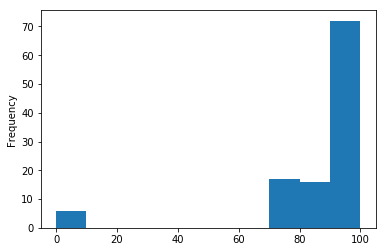

In [9]:
df_null_pct.plot(kind='hist')

The situation is bad. Most of the features have at least 80% of null values, with a high amout above 90%. One could choose to try to input those values, but that would be a colossal assumption (to input 90% based on 10%) and render our model useless. Garbabe In, Garbage Out. It may hurt, but I chose to drop all columns containing at least 90% of null values.

### Remove Features with > 90% null values

In [77]:
nulls = df_null_pct[df_null_pct > 90]

df = df[[col for col in df.columns if col not in nulls]]

df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,"Influenza B, rapid test","Influenza A, rapid test",has_disease
0,44477f75e8169d2,13,0,0,0,0,0.034267,0.022490,-0.070137,0.061030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,a46b4402a0e5696,8,0,0,0,0,-0.041190,-0.019496,0.052728,-0.040502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f7d619a94f97c45,5,0,0,0,0,-0.086463,-0.044687,0.126447,-0.101422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,d9e41465789c2b5,15,0,0,0,0,0.064449,0.039284,-0.119284,0.101643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


That left us with 39 variables out of 101.

Next, I will check the variances to see if there is any variable with a single value.

### Check Variances

In [13]:
features = [col for col in df.columns if col not in ['Patient ID', 
                                                    'Patient addmited to regular ward (1=yes, 0=no)',
                                                    'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                                                    'Patient addmited to intensive care unit (1=yes, 0=no)',
                                                    'SARS-Cov-2 exam result']]

df[features].var()

Patient age quantile                                33.384166
Hematocrit                                           1.001661
Hemoglobin                                           1.001661
Platelets                                            1.001664
Mean platelet volume                                 1.001672
Red blood Cells                                      1.001664
Lymphocytes                                          1.001664
Mean corpuscular hemoglobin concentration (MCHC)     1.001664
Leukocytes                                           1.001664
Basophils                                            1.001664
Mean corpuscular hemoglobin (MCH)                    1.001664
Eosinophils                                          1.001664
Mean corpuscular volume (MCV)                        1.001664
Monocytes                                            1.001667
Red blood cell distribution width (RDW)              1.001664
Respiratory Syncytial Virus                          0.036957
Influenz

We can see that variable "Parainfluenza 2" has 0 variance, meaning it has only one value. Will drop that column.

In [14]:
df.drop('Parainfluenza 2', axis=1, inplace=True)
features.remove('Parainfluenza 2')

### Create 'has_disesase' variable

I've realized that the last 19 columns of the dataset are all related to the presence of antigens - all those variables are binary. When we analyze them one by one, the amount of nulls is very high. But, if we take the sum rowise, the null percentage decreases. This variable indicates, for each patient, if *at least* one of those variables is positive. 

Here I am making an assumption to fill the remaining nulls: if all those columns are null, I'll assume that the patient doesn't have any of those diseases (has_disease = 0). There might be cases where this is false and the person simply wasn't tested, but it may be a good approximation.

In [15]:
df['has_disease'] = df[df.columns[20:]].sum(axis=1)

df.loc[df['has_disease'] > 1, 'has_disease'] = 1

df['has_disease'].value_counts(normalize=True)

0.0    0.865344
1.0    0.134656
Name: has_disease, dtype: float64

13% percent of the patients have tested positive for at least one of the antigens. Now let's see how the target behaves for those people:

In [16]:
df[df['has_disease'] == 1]['SARS-Cov-2 exam result'].value_counts(normalize=True)

0    0.981579
1    0.018421
Name: SARS-Cov-2 exam result, dtype: float64

Indeed, this variable is promising. Of all the patients with a disease, only ~2% tested positive for COVID-19, as opposed to ~10% on the whole dataset. This indicates a strong relationship between having another disease and *not* being infected by COVID-19.

### Inpute 'disease' variables with 0

Here, I am making a pretty big assumption: in cases where it was not informed if the patient had the virus/disease, I will assume that he didn't have it.

In [18]:
df_clean = df.copy()

df[df.columns[20:]] = df[df.columns[20:]].fillna(0)

## Input 'blood variables' via regression (using Age)

<a id="input"></a>

For the other variables, which I called 'blood variables' and are all continuous, I'll attempt to input missing values via Linear Regression, using Age as my independent variable. This is a big hypothesis and will only work if there is a clear relationship between variable and age, which I don't expect to happen. Still, I'll give it a try nonetheless.

In [21]:
for feature in df[df.columns[6:20]]:
    df_age_var = df.dropna(axis=0, subset=['Patient age quantile', feature]).loc[:, ['Patient age quantile',
                                                                                          feature]]
    missing = df[feature].isnull()
    age_missing = pd.DataFrame(df['Patient age quantile'][missing])

    X = df_age_var[['Patient age quantile']]
    y = df_age_var[feature]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lm = LinearRegression().fit(X_train, y_train)

    df.loc[df[feature].isna(), feature] = lm.predict(age_missing)
    
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,"Influenza B, rapid test","Influenza A, rapid test",has_disease
0,44477f75e8169d2,13,0,0,0,0,0.034267,0.022490,-0.070137,0.061030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,a46b4402a0e5696,8,0,0,0,0,-0.041190,-0.019496,0.052728,-0.040502,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f7d619a94f97c45,5,0,0,0,0,-0.086463,-0.044687,0.126447,-0.101422,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,d9e41465789c2b5,15,0,0,0,0,0.064449,0.039284,-0.119284,0.101643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
df.isna().sum().sum()

0

As one can see, after imputation, there are no nulls left on the dataset. It is ready for modeling.

However, let's check how our regression is imputing the values. Let's take, for instance, Hematocrit:

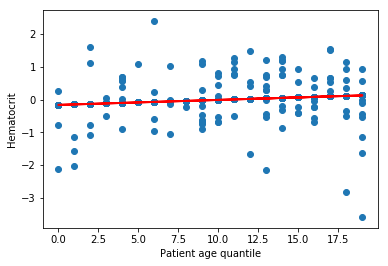

In [22]:
df_age_var = df.dropna(axis=0, subset=['Patient age quantile', 'Hematocrit']).loc[:, ['Patient age quantile',
                                                                                      'Hematocrit']]

missing_hem = df['Hematocrit'].isnull()
age_missing_hem = pd.DataFrame(df['Patient age quantile'][missing_hem])

X = df_age_var[['Patient age quantile']]
y = df_age_var['Hematocrit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', lw=2)
plt.xlabel('Patient age quantile')
plt.ylabel('Hematocrit')
plt.show()

Terrible, terrible, terrible! We observe that the variable has very high *heteroskedasticity*, i.e., high dispersion. Since y values vary greatly for the same value of x (age), we are basically just inputing by the mean - which, of course, won't represent real data. 

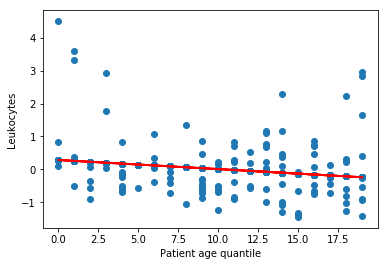

In [23]:
df_age_var = df.dropna(axis=0, subset=['Patient age quantile', 'Leukocytes']).loc[:, ['Patient age quantile',
                                                                                      'Leukocytes']]

missing_leu = df['Leukocytes'].isnull()
age_missing_leu = pd.DataFrame(df['Patient age quantile'][missing_leu])

X = df_age_var[['Patient age quantile']]
y = df_age_var['Leukocytes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red', lw=2)
plt.xlabel('Patient age quantile')
plt.ylabel('Leukocytes')
plt.show()

The same for Leukocytes. Even though the line slightly captures the trend, it is still not even close to ideal.

Let's try to build a simple Random Forest model and see the tragedy that awaits us.

### Simple Random Forest Model

In [27]:
def fit_and_print(model):
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    #CM and Acc
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))  
    print("Classification Report: \n", classification_report(y_test, y_pred))  
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))   
    print("Recall Score:", recall_score(y_test, y_pred))
    #AUC and KS
    print("AUC: ", roc_auc_score(y_test, y_pred))
    print("KS: ", ks_2samp(y_pred[y_test == 0], y_pred[y_test == 1]).statistic)
    
X = df[features].values 
y = df['SARS-Cov-2 exam result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Split between test and train!")

#Apply RF
rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=42)  

fit_and_print(rf)

Split between test and train!
Confusion Matrix: 
 [[1016    1]
 [ 107    5]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1017
           1       0.83      0.04      0.08       112

    accuracy                           0.90      1129
   macro avg       0.87      0.52      0.52      1129
weighted avg       0.90      0.90      0.86      1129

Accuracy Score:  0.9043401240035429
Recall Score: 0.044642857142857144
AUC:  0.5218297864868662
KS:  0.04365957297373227


Expected. The model basically predicts all the time that the individual is not infected (ridiculous Recall). We won't be able to use the whole dataset, much less inpute the missing values this way.

## Improve the dataset

<a id="smaller"></a>

In [28]:
print('Total Columns: ', df_clean.shape[1])
df_clean.isna().sum(axis=1).value_counts()

Total Columns:  39


32    3596
16     917
30     458
2      263
14     166
18     139
0       99
3        4
27       1
29       1
dtype: int64

Out of 5644 rows, 3596 have 32 columns with missing values (out of 39). This gives us a place to start.

The first reduction will be to trim the dataset to one whose rows don't have more than 26 null columns.

In [29]:
df_red = df_clean[df_clean.isna().sum(axis=1) < 26]

df_red.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,"Influenza B, rapid test","Influenza A, rapid test",has_disease
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,d9e41465789c2b5,15,0,0,0,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0
8,8bb9d64f0215244,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
9,5f1ed301375586c,17,0,0,0,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
13,0fbafd910aa8078,13,0,0,0,0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0


Let's check null percentage by column once again.

In [30]:
df_null_pct = df_red.isna().mean().round(4) * 100

df_null_pct.sort_values(ascending=False)

Influenza A, rapid test                                  77.20
Influenza B, rapid test                                  77.20
Mean platelet volume                                     62.28
Monocytes                                                62.15
Leukocytes                                               62.09
Mean corpuscular volume (MCV)                            62.09
Eosinophils                                              62.09
Mean corpuscular hemoglobin (MCH)                        62.09
Basophils                                                62.09
Red blood cell distribution width (RDW)                  62.09
Mean corpuscular hemoglobin concentration (MCHC)         62.09
Red blood Cells                                          62.09
Platelets                                                62.09
Hemoglobin                                               62.09
Hematocrit                                               62.09
Lymphocytes                                            

We can see that blood variables have equal amount of nulls. For my modeling, I will be considering only the rows containing full data on blood variables. The effect of the other columns, hopefully, will be concentrated on the "has_disease" variable. This way, I can keep both "types" of variables in modeling.

In [31]:
df_red = df_red[df_red['Leukocytes'].notna()]

df_null_pct = df_red.isna().mean().round(4) * 100

df_null_pct.sort_values(ascending=False)

Influenza B, rapid test                                  67.44
Influenza A, rapid test                                  67.44
CoronavirusNL63                                          39.20
Chlamydophila pneumoniae                                 39.20
Respiratory Syncytial Virus                              39.20
Influenza A                                              39.20
Influenza B                                              39.20
Parainfluenza 1                                          39.20
Rhinovirus/Enterovirus                                   39.20
Parainfluenza 3                                          39.20
Coronavirus HKU1                                         39.20
Adenovirus                                               39.20
Parainfluenza 4                                          39.20
Coronavirus229E                                          39.20
CoronavirusOC43                                          39.20
Inf A H1N1 2009                                        

There are still two blood variables with a minor percentage of nulls (0.5% and 0.17%). In this case, since it's just very few samples, I will inpute by the mean.

In [32]:
df_red.loc[df_red['Mean platelet volume '].isna(), 'Mean platelet volume '] = df_red['Mean platelet volume '].mean()

df_red.loc[df_red['Monocytes'].isna(), 'Monocytes'] = df_red['Monocytes'].mean()

### Remove Variables

Keep only blood variables and has_disease.

In [33]:
cols_to_remove = [c for c in df_red.columns[20:-1]]
df_feat = df_red.drop(cols_to_remove, axis=1)

#update features
features = [c for c in df_feat.columns if c not in ['Patient ID', 'SARS-Cov-2 exam result',
                                                   'Patient addmited to regular ward (1=yes, 0=no)',
                                                   'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                                                   'Patient addmited to intensive care unit (1=yes, 0=no)']]

df_feat.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),has_disease
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.022340,-0.517413,0.010677,...,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,1.0
8,8bb9d64f0215244,1,0,0,1,0,-1.571682,-0.774212,1.429667,-1.672222,...,-0.005738,3.331071,0.364550,-0.223767,0.178175,1.018625,-1.336024,0.068652,-0.978899,0.0
15,6c9d3323975b082,9,0,0,0,0,-0.747693,-0.586244,-0.429480,-0.213711,...,-1.114514,0.542882,-0.884923,0.081693,1.746323,-0.666950,1.668409,1.276759,-1.067355,1.0
18,d3ea751f3db9de9,11,0,0,0,0,0.991838,0.792188,0.072992,-0.550290,...,0.045436,-0.452899,-0.211488,-0.834685,0.334989,-0.709090,0.606842,-0.220244,0.171035,1.0
22,2c2eae16c12a18a,9,0,0,0,0,0.190738,-0.147652,-0.668155,1.020415,...,0.002791,-1.249524,-1.132592,0.387152,-0.083183,-0.709090,0.566783,2.012129,0.613318,0.0


In [34]:
df_feat.isna().sum().sum()

0

Once again, ready for modeling.

But first, let's take a look at correlations.

### Correlations

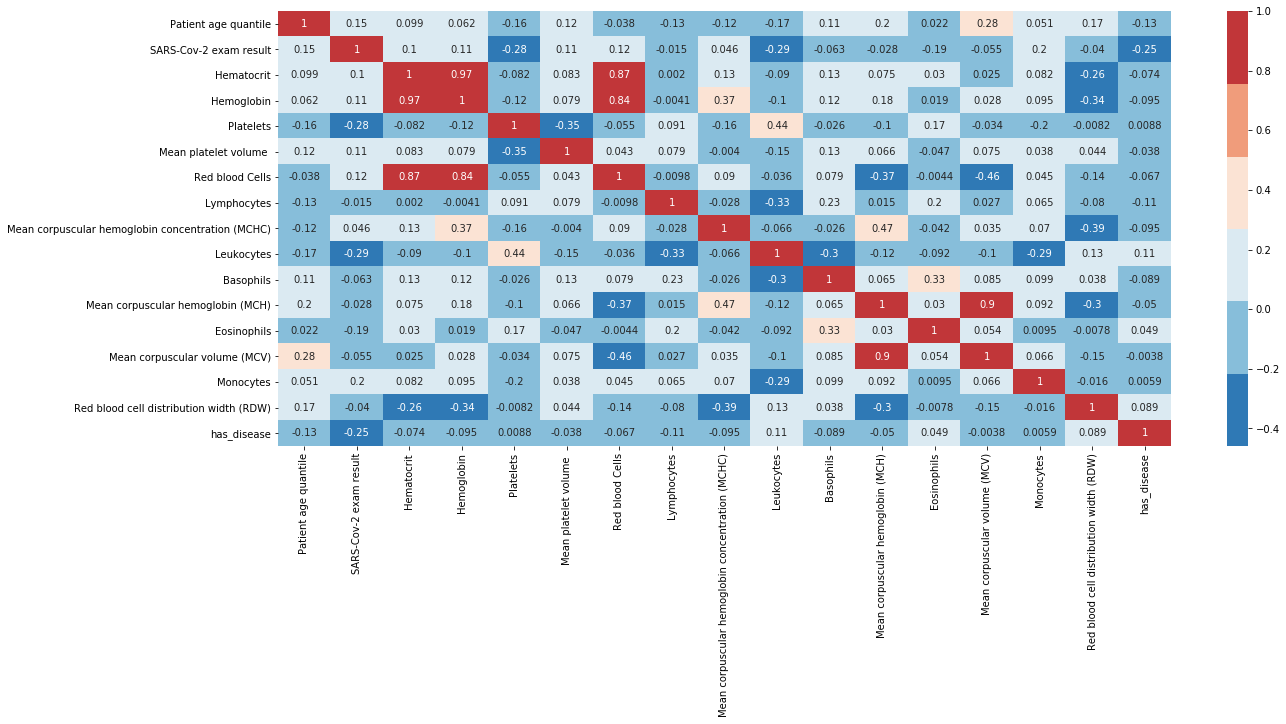

In [35]:
corr = df_feat.drop(['Patient ID', 'Patient addmited to regular ward (1=yes, 0=no)', 
             'Patient addmited to semi-intensive unit (1=yes, 0=no)',
             'Patient addmited to intensive care unit (1=yes, 0=no)'], axis=1).corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.color_palette('RdBu_r'), 
            annot=True)

plt.show()

Using a correlation heatmap, we can get a sense of the most important variables for the target (second line). Leukocytes, Platelets and has_disease have near -0.3 correlation - they will be important variables. Monocytes and age, on the other hand, have a slight positive correlation. 

Some features have a high correlation within themselves, so we have to make decisions in order to reduce noise. Hematocrit and Hemoglobin basically mean the same thing (0.97 correlation). They have very high correlation with Red blood Cells as well (0.87 and 0.84, respectively). Their correlations with the target are very similar as well, so I'll keep the one with the highest (Red Blood Cells, 0.12). The other two hightly correlated variables are MCV and MCH - in this case, MCV is more correlated to the target (-0.055 vs. -0.028), so I'll keep it.

- Keep: MCV, Red blood Cells
- Remove: MCH, Hematocrit, Hemoglobin

In [36]:
df_feat = df_feat.drop(['Mean corpuscular hemoglobin (MCH)', 'Hematocrit', 'Hemoglobin'], axis=1)
#update features
features = [f for f in features if f not in ['Mean corpuscular hemoglobin (MCH)', 'Hematocrit', 'Hemoglobin']]

### Retrain Simple Random Forest

In [37]:
X = df_feat[features]
y = df_feat['SARS-Cov-2 exam result'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print("Split between test and train!")

#Apply RF
rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=42)  
fit_and_print(rf)

Split between test and train!
Confusion Matrix: 
 [[101   3]
 [ 11   6]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.97      0.94       104
           1       0.67      0.35      0.46        17

    accuracy                           0.88       121
   macro avg       0.78      0.66      0.70       121
weighted avg       0.87      0.88      0.87       121

Accuracy Score:  0.8842975206611571
Recall Score: 0.35294117647058826
AUC:  0.6620475113122172
KS:  0.3240950226244344


Still far from ideal, but we can see an improvement! Obviously our test set is very small, but we went from 4% Recall to 35%. At least the model has *some* capacity to distinguish classes.

Next, let's see if we can improve results using GridSearch.

The metric chosen is **Recall**, since we are more interested in minimizing the *False Negatives* (people predicted to be healthy, when in fact are infected).

### GridSearch

In [38]:
random_grid = {'n_estimators': [10, 50, 100, 200, 500],
            'max_features': ['auto', 'sqrt', 'log2', 5, 10, 30],
            'max_depth': [2, 8, 16, 32, 64, 128],
            'min_samples_split': [1,2,4,8,16,24],
            'min_samples_leaf': [1,2,5,10,15,30]}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                            n_iter = 200, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
fit_and_print(rf_random)
print(rf_random.best_params_)

Confusion Matrix: 
 [[100   4]
 [ 11   6]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       104
           1       0.60      0.35      0.44        17

    accuracy                           0.88       121
   macro avg       0.75      0.66      0.69       121
weighted avg       0.86      0.88      0.86       121

Accuracy Score:  0.8760330578512396
Recall Score: 0.35294117647058826
AUC:  0.6572398190045249
KS:  0.31447963800904977
{'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 64}


Nothing changed. As a next step, let's try to overcome our imbalance problem with an *oversampling* technique called SMOTE. Basically, SMOTE synthetically creates minority class samples to deal with imbalanced classification. More on the technique can be found on https://arxiv.org/abs/1106.1813

## SMOTE

<a id="smote"></a>

In [40]:
smt = SMOTE(k_neighbors=5, random_state=42)
X_train, y_train = smt.fit_sample(X_train, y_train)

np.bincount(y_train)

array([415, 415])

Now our training set has class balance, thanks to synthetic oversampling of minority class.

### Retrain simple Random Forest with SMOTE

In [41]:
rf = RandomForestClassifier(n_estimators=100, max_features='auto', random_state=42)  
fit_and_print(rf)

Confusion Matrix: 
 [[100   4]
 [  6  11]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       104
           1       0.73      0.65      0.69        17

    accuracy                           0.92       121
   macro avg       0.84      0.80      0.82       121
weighted avg       0.91      0.92      0.92       121

Accuracy Score:  0.9173553719008265
Recall Score: 0.6470588235294118
AUC:  0.8042986425339366
KS:  0.6085972850678733


Much better! Oversampling with SMOTE helps the model to distinguish between positive and negative results. We reached a Recall of 65%, which is somewhat acceptable. 

Finally, we will try to improve this result using GridSearch + SMOTE.

## GridSearch + SMOTE

<a id="model"></a>

In [46]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                            n_iter = 300, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
fit_and_print(rf_random)
print(rf_random.best_params_)

Confusion Matrix: 
 [[98  6]
 [ 5 12]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       104
           1       0.67      0.71      0.69        17

    accuracy                           0.91       121
   macro avg       0.81      0.82      0.82       121
weighted avg       0.91      0.91      0.91       121

Accuracy Score:  0.9090909090909091
Recall Score: 0.7058823529411765
AUC:  0.8240950226244345
KS:  0.6481900452488688
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 8}


Even better!

I think this is very close to the limit we can achieve, given dataset complications. Recall (71%) is not overly high but still acceptable, and the model is still able to correctly classify non-infected (91% Accuracy). This means that we have reduced the False Negatives (very costly), without having to sacrifice too many False Positives (less expensive, but still would have to test healthy people).

Still, let's try some other models.

### Try Logistic Regression 

In [49]:
random_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100, 10, 1, 0.1, 0.01, 0.001]
    }
lr = LogisticRegression()

lr_random = RandomizedSearchCV(estimator = lr, param_distributions = random_grid, 
                            n_iter = 100, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
fit_and_print(lr_random)
print(lr_random.best_params_)

The total space of parameters 12 is smaller than n_iter=100. Running 12 iterations. For exhaustive searches, use GridSearchCV.


Confusion Matrix: 
 [[90 14]
 [ 5 12]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.87      0.90       104
           1       0.46      0.71      0.56        17

    accuracy                           0.84       121
   macro avg       0.70      0.79      0.73       121
weighted avg       0.88      0.84      0.86       121

Accuracy Score:  0.8429752066115702
Recall Score: 0.7058823529411765
AUC:  0.785633484162896
KS:  0.5712669683257918
{'penalty': 'l2', 'C': 100}


Very similar to RF, but less able to correctly classify negative class.

### Try KNN

In [50]:
random_grid = {
    'n_neighbors': [2, 3, 5, 8, 10, 12, 15, 20, 30],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
    }
knn = KNeighborsClassifier()

knn_random = RandomizedSearchCV(estimator = knn, param_distributions = random_grid, 
                            n_iter = 100, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
fit_and_print(knn_random)
print(knn_random.best_params_)

The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.


Confusion Matrix: 
 [[80 24]
 [ 7 10]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       104
           1       0.29      0.59      0.39        17

    accuracy                           0.74       121
   macro avg       0.61      0.68      0.61       121
weighted avg       0.83      0.74      0.78       121

Accuracy Score:  0.743801652892562
Recall Score: 0.5882352941176471
AUC:  0.6787330316742082
KS:  0.3574660633484163
{'weights': 'distance', 'p': 1, 'n_neighbors': 2}


Not helpful.

### Try SVM

In [51]:
random_grid = {'C': [0.1, 1, 10, 100, 1000], 
               'gamma': ['auto', 1, 0.1, 0.01, 0.001, 0.0001], 
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  

svc = SVC()

svc_random = RandomizedSearchCV(estimator = svc, param_distributions = random_grid, 
                            n_iter = 200, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
fit_and_print(svc_random)
print(svc_random.best_params_)

The total space of parameters 120 is smaller than n_iter=200. Running 120 iterations. For exhaustive searches, use GridSearchCV.


Confusion Matrix: 
 [[ 8 96]
 [ 0 17]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.08      0.14       104
           1       0.15      1.00      0.26        17

    accuracy                           0.21       121
   macro avg       0.58      0.54      0.20       121
weighted avg       0.88      0.21      0.16       121

Accuracy Score:  0.2066115702479339
Recall Score: 1.0
AUC:  0.5384615384615384
KS:  0.07692307692307693
{'kernel': 'sigmoid', 'gamma': 1, 'C': 0.1}


Inverse of the first Random Forest we fitted. Here it basically tells that everyone is infected. Even though we wouldn't have any False Negatives, we would have to test everyone - this is useless.

In [79]:
import xgboost as xgb

random_grid = {"n_estimators": [100, 500, 1000],
              "learning rate": [0.1, 0.05, 0.01],
              "max_depth": [2, 8, 16, 64, 128], 
              "colsample_bytree": [0.3, 0.8, 1],
              "gamma": [0,1,5]}  

xgb_clf = xgb.XGBClassifier(objective='binary:logistic')

xgb_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = random_grid, 
                            n_iter = 200, cv = 5, scoring = 'recall', 
                            verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
fit_and_print(xgb_random)
print(xgb_random.best_params_)

Confusion Matrix: 
 [[96  8]
 [ 6 11]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       104
           1       0.58      0.65      0.61        17

    accuracy                           0.88       121
   macro avg       0.76      0.79      0.77       121
weighted avg       0.89      0.88      0.89       121

Accuracy Score:  0.8842975206611571
Recall Score: 0.6470588235294118
AUC:  0.7850678733031674
KS:  0.5701357466063348
{'n_estimators': 500, 'max_depth': 128, 'learning rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}


Similar result to Random Forest, but not better. XGB probably would have achieved the same result as RF (only 1 FN more) with a more thorough GridSearch. Problem is, dataset is too small!

### Feature Importances

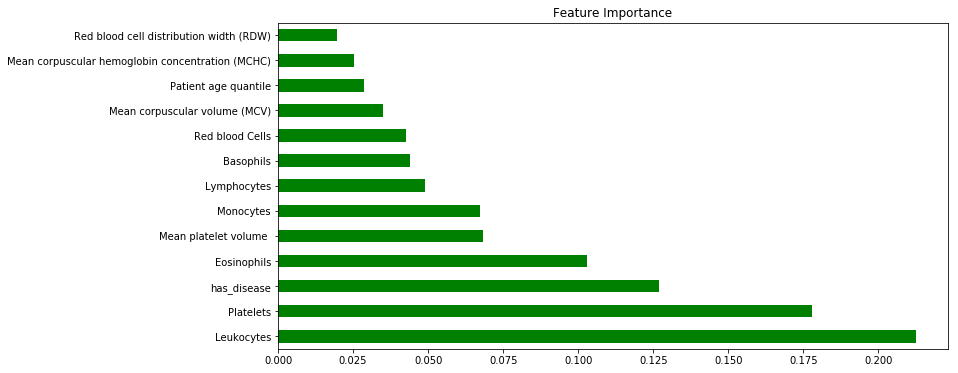

Leukocytes                                          21.246895
Platelets                                           17.778327
has_disease                                         12.682607
Eosinophils                                         10.302348
Mean platelet volume                                 6.841700
Monocytes                                            6.726247
Lymphocytes                                          4.909769
Basophils                                            4.404982
Red blood Cells                                      4.260504
Mean corpuscular volume (MCV)                        3.503431
Patient age quantile                                 2.853957
Mean corpuscular hemoglobin concentration (MCHC)     2.536316
Red blood cell distribution width (RDW)              1.952917
Name: importance, dtype: float64


In [52]:
feature_importances = pd.DataFrame(rf_random.best_estimator_.feature_importances_,
                                index = features,
                                    columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(12,6))
feature_importances.importance.plot(kind='barh', color='green')
plt.title('Feature Importance')
plt.show()
feature_importances.style.format({'importance': '{:.1%}'.format})
print(feature_importances.importance*100)

The most important features are very similar to the ones we saw on the correlation heatmap.

- Leukocytes
- Platelets
- has_disease
- Eosionophils
- Mean platelet volume
- Monocytes

Another good thing about the model is that age is the third less important feature - I think this is good, given that we know that there is an age relationship, but would like other features to be more relevant.

Lastly, let's use SHAP Values to help us understand our model's predictions. You can read more about this wonderful technique on https://christophm.github.io/interpretable-ml-book/shap.html

## SHAP Values

<a id="shap"></a>

In [53]:
X = df_feat[features] 
y = df_feat['SARS-Cov-2 exam result'].values
_, X_test, _, _ = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

y_pred = rf_random.best_estimator_.predict(X_test)

explainer = shap.TreeExplainer(rf_random.best_estimator_)
expected_value = explainer.expected_value[1]

shap_values = explainer.shap_values(X_test)[1]
shap_interaction_values = explainer.shap_interaction_values(X_test)[1]
np.save('shap_values.npy', shap_values)

print(expected_value)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


0.499253012048193


We can use Decision Plots to see, for each instance, the impact of each variable on the base value. In all subsequent plots the base value is 0.5; values above it are classified as positive and below it, negative. Features are ranked in the plot by their importance to that specific observation.

### True Positive Examples

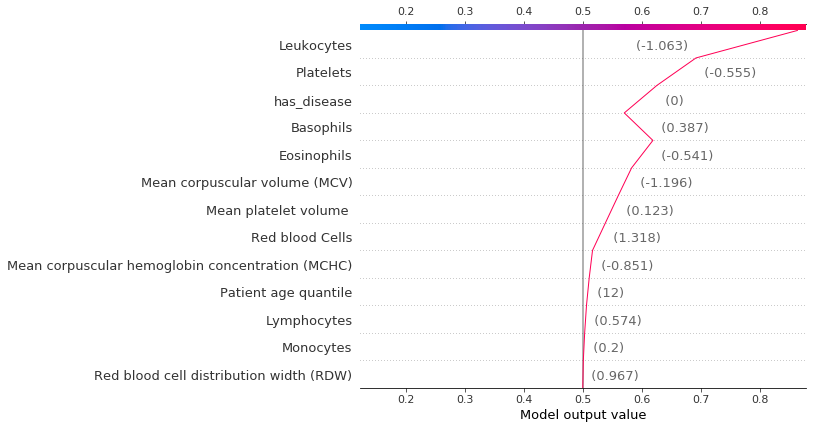

In [54]:
shap.decision_plot(expected_value, shap_values[34], X_test.iloc[34])

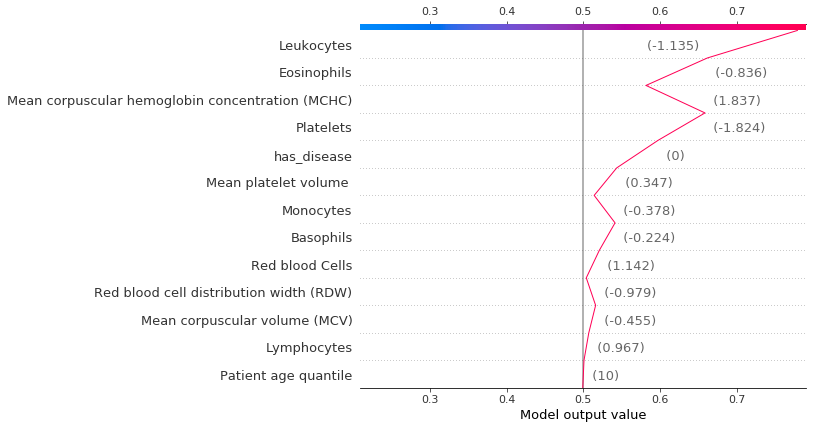

In [59]:
shap.decision_plot(expected_value, shap_values[87], X_test.iloc[87])

We can see that in both examples that the low value of Leukocytes had the greatest influence in order to classify them as positives. Age and Lymphocytes, on the other hand, had minimal impact. Their "prediction path" is similar, but the order of the variables change (for instance, Platelets was the 2nd most important for the first patient, whereas the 4th for the second). This kind of analysis is very helpful to understand the impact of each feature for each patient.

### True Negative Example

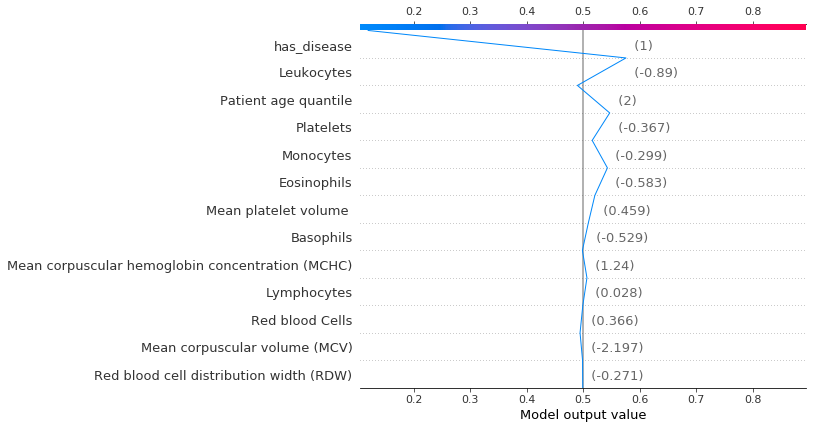

In [62]:
shap.decision_plot(expected_value, shap_values[33], X_test.iloc[33])

In this example, we can see that considering all other variables besides has_disease, this patient would be classified as positive. The fact that he/she has a disease, however, "abruptly" changes the decision to not infected. This is an indication that blood variables are similar to a COVID-19 infected person, but this is due to the fact that he/she has another disease.

### False Positive Example

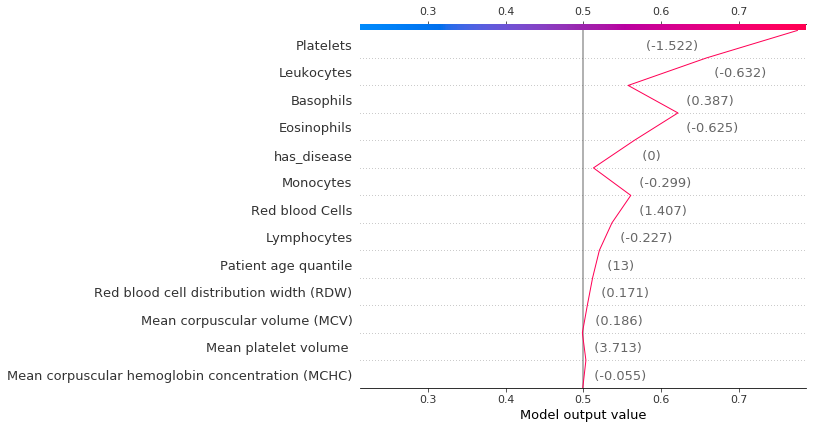

In [65]:
shap.decision_plot(expected_value, shap_values[57], X_test.iloc[57])

False positives are tricky, at least to me, to analyze, since I have little medical expertise. But hopefully a doctor can extract knowledge from this kind of plot (from what I understand, this person has Platelets and Leukocytes very similar to healthy people, but was infected).

### False Negative Example

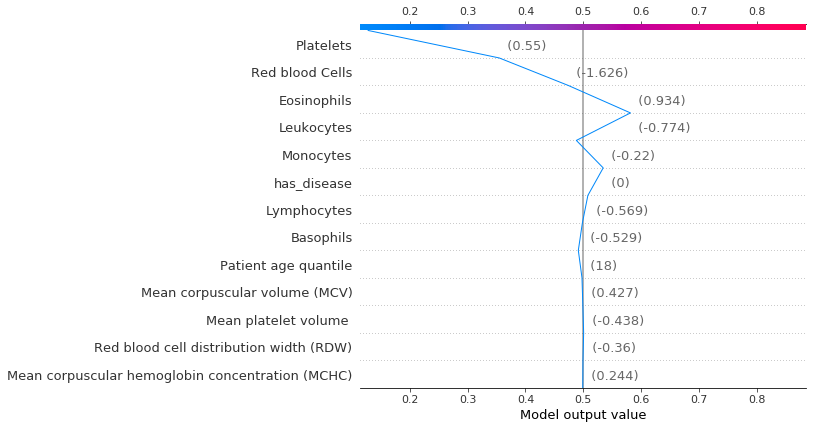

In [68]:
shap.decision_plot(expected_value, shap_values[40], X_test.iloc[40])

The same analysis can be done to the false negatives. In this case, the two variables that greatly pushed the prediction to "healthy" were Platelets and Red blood Cells. This indicates that, for this individual, even though he was infected, this two variables indicate otherwise.

### Dependence Plots

Another way SHAP can help us understand model predictions is to use Dependence Plots. They plot the SHAP values for a given variable on y axis and variable value on x axis. The plot automatically colors the points with a variable estimated to have the higher correlation. Positive SHAP values indicate that the feature is "helping" the positive class (i.e., pushing the prediction to be "infected"), whereas negative SHAP values indicate that the feature is pushing the prediction to be "not-infected". This way, we can see how SHAP values vary with feature value.

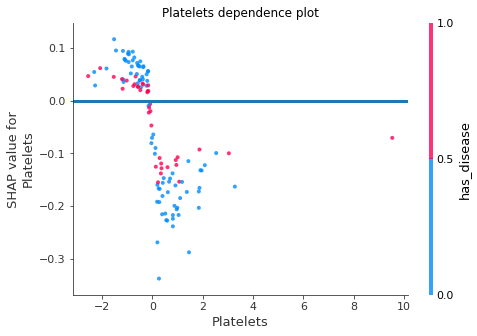

In [69]:
shap.dependence_plot("Platelets", shap_values, X_test, alpha=0.8, show=False)
plt.title("Platelets dependence plot")
plt.axhline(0, lw=3)
plt.show()

For platelets, there is a clear relationship between low values (help "infected") and high values (help "non-infected"), though it is not linear and somewhat muddy around 0.

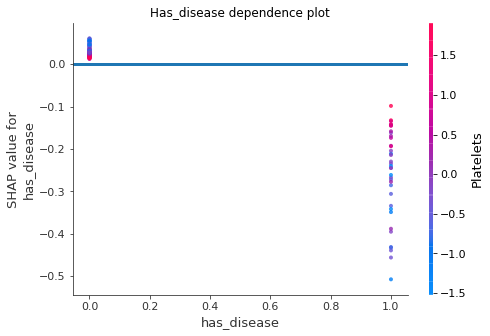

In [70]:
shap.dependence_plot("has_disease", shap_values, X_test, alpha=0.8, show=False)
plt.title("Has_disease dependence plot")
plt.axhline(0, lw=3)
plt.show()

Another good sign that our model is calibrated is that all people with a previous disease helped the prediction to be not-infected. And, given that the person has a disease, the higher the value of Platelets (blue points), the more the prediction is pushed towards "not-infected".

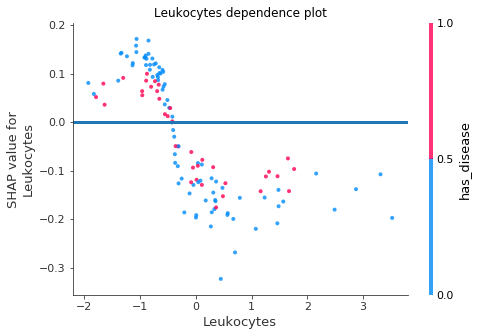

In [71]:
shap.dependence_plot("Leukocytes", shap_values, X_test, alpha=0.8, show=False)
plt.title("Leukocytes dependence plot")
plt.axhline(0, lw=3)
plt.show()

Basically the same behavior of Platelets is observed for Leukocytes.

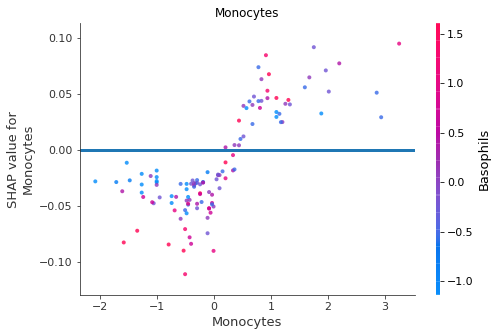

In [80]:
shap.dependence_plot("Monocytes", shap_values, X_test, alpha=0.8, show=False)
plt.title("Monocytes")
plt.axhline(0, lw=3)
plt.show()

For Monocytes, the trend is clear as well. Higher values push the predictions to "infected".

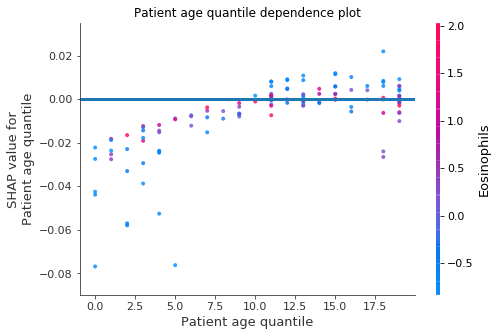

In [72]:
shap.dependence_plot("Patient age quantile", shap_values, X_test, alpha=0.8, show=False)
plt.title("Patient age quantile dependence plot")
plt.axhline(0, lw=3)
plt.show()

And for the age, the known relationship of increasing risk is observed as well. There is a clear trend: model pushes predictions towards "infected" for older patients. All patients below age quantile 10 pushed prediction towards "not infected". However, for older people sometimes the model pushes observations towards "not infected", meaning that age does not have a perfect linear relationship with infection.

### Summary Plot

We can look at a Summary Plot as well - this gives all SHAP values for every feature, displayed horizontally. Feature value is used as color and features are ranked by importance.

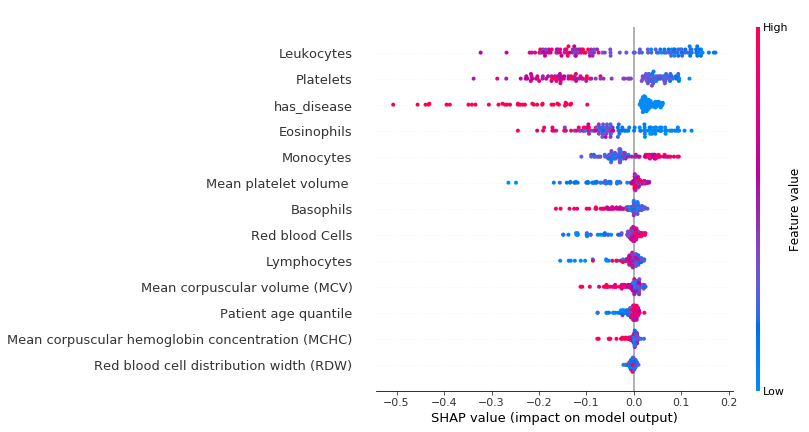

In [73]:
shap.summary_plot(shap_values, X_test)

This confirms and summarizes all of our previous findings. Low values for Leukocytes, Platelets and Eosinophils are a strong indicator of COVID-19 presence, as well as the has_disease variable. High values of Monocytes are a strong indicator of COVID-19 presence. For the other variables SHAP Values are highly skewed towards "not infected" (negative values), with a somewhat "muddy terrain" around 0.

### All False Negative (FN) Predictions

We again use a decision plot, this time to look at the prediction paths of all the 5 False Negatives.

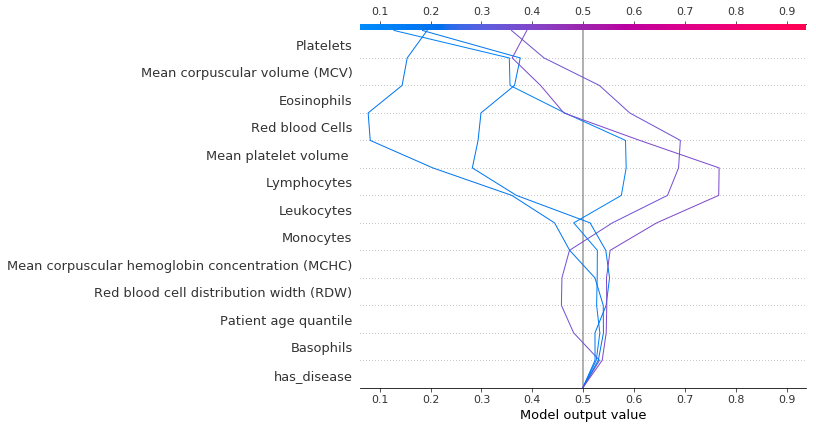

In [76]:
X_fn = X_test[(y_pred==0) & (y_test == 1)]
shap_fn = shap_values[(y_pred==0) & (y_test == 1)]

shap.decision_plot(expected_value, shap_fn, X_fn, feature_order='hclust')

The main takeaway is that there is no "single path" that leads to False Negative predictions. Two of the classifications were close to the decision threshold (two lines near 0.4), while the other 3 were "pretty sure the patient is not infected". Once again, I have no medical expertise to thoroughly analyze this, but hopefully a doctor can make sense of this.

## Conclusion

<a id="conclusion"></a>

I conducted an analysis, based on 101 variables from 5644 records kindly provided by Hospital Israelita Albert Einstein, to predict if a patient was infected by COVID-19 or not. I chose to maximize the *Recall* metric, given how costly a False Negative is.

After dealing with missing data, conducting oversampling with SMOTE and conducting GridSearch with a lot of models, the best result came from **Random Forest**, with 71% Recall, 91% Accuracy and 82% AUC. This is an acceptable value for Recall without sacrificing Accuracy (thus, few False Positives), and the model should perform much better with more data.

I also used SHAP to better understand model predictions, with the main takeaways being:

- Low values for Leukocytes, Platelets and Eosinophils are a strong indicator of COVID-19 presence;
- If a person tested positive for any of the diseases contained in the dataset, it is highly likely that he/she will *not* have the COVID-19; 
- High values of Monocytes are a strong indicator of COVID-19 presence;
- For the other variables SHAP Values are highly skewed towards "not infected", becoming less certain for neutral and positive contributions for "infected";
- There is no "single path" that leads to False Negative predictions. The implications and meanings have to be better assessed by a doctor.

I hope this work can be helpful in any way :D

Stay home and be safe!